In [1]:
import random, os
import numpy as np
import torch

def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

# Load data

In [2]:
import datasets
import pandas as pd
from ast import literal_eval


uit_vsfc_test_dir = '../input/edit-uit-vsfc/test.csv'
aivivn_test_dir = '../input/aivivn-2019/test.csv'



## Load uit_vsfc

In [3]:
uit_vsfc_test_df = pd.read_csv(uit_vsfc_test_dir)
uit_vsfc_test_df = pd.DataFrame({
    'text': uit_vsfc_test_df['comment'],
    'label': uit_vsfc_test_df['label'].map({2: 'POS', 0: 'NEG', 1:'NEU'})
})

In [4]:
uit_vsfc_test_df

,text,label
0,nói tiếng anh lưu loát .,POS
1,giáo viên rất vui tính .,POS
2,cô max có tâm .,POS
3,"giảng bài thu hút , dí dỏm .",POS
4,"giáo viên không giảng dạy kiến thức , hướng dẫ...",NEG
...,...,...
3161,"các slide khó hiểu , ngôn ngữ trong slide phức...",NEG
3162,giáo viên giảng dạy có tâm huyết .,POS
3163,chia sẻ cho em nhiều điều hay .,POS
3164,em tiếp thu chậm .,NEG


In [5]:
label_counts = uit_vsfc_test_df['label'].value_counts()

print(label_counts)

label
POS    1590
NEG    1409
NEU     167
Name: count, dtype: int64


## Load aivivn-2019

In [6]:
aivivn_test_df = pd.read_csv(aivivn_test_dir)

aivivn_test_df = pd.DataFrame({
    'text': aivivn_test_df['comment'],
    'label': aivivn_test_df['label'].map({1: 'POS', 0: 'NEG'})
})

In [7]:
aivivn_test_df

,text,label
0,Trả lời rất nhiệt tình gói hàng cẩn thận quá t...,POS
1,Sản phẩm không đúng như rao bán.,NEG
2,Chất lượng sản phẩm tuyệt vời! Shop phục vụ rấ...,POS
3,Bim tốt. Ung hộ shop dai dai,POS
4,Hộp còn nguyên tem chưa có dấu hiệu bị bóc son...,POS
...,...,...
3212,Sản phẩm tốt rất chắc chắn,POS
3213,Giày đẹp hơn mong đợicòn có tờ giấy cám ơn nhỏ...,POS
3214,Đóng gói cẩn thận giao hàng nhanh. Chất lượng ...,POS
3215,Đồng hồ yêu lắm ạ thích lắm luôn 😘😘😘,POS


In [8]:

label_counts = aivivn_test_df['label'].value_counts()

print(label_counts)


label
POS    1856
NEG    1361
Name: count, dtype: int64


# Test

In [9]:
import os
import gc
import json
import numpy as np
from scipy import interpolate
from pathlib import Path
import torch
from torch import nn
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def evaluate(true_labels, predicts):
    test_accuracy = accuracy_score(true_labels, predicts)
    test_precision = precision_score(true_labels, predicts, average='macro')
    test_recall = recall_score(true_labels, predicts, average='macro')
    test_f1 = f1_score(true_labels, predicts, average='macro')
    test_cm = confusion_matrix(true_labels, predicts)

    print("Accuracy: {:.4f}".format(test_accuracy))
    print("Precision: {:.4f}".format(test_precision))
    print("Recall: {:.4f}".format(test_recall))
    print("F1-score: {:.4f}".format(test_f1))
    print("Confusion matrix:\n", test_cm)
    print(classification_report(true_labels, predicts, digits=4))

    return test_cm


def plotting_confusion_matrix(labels, confusion_matrix, model_name):
    Path(model_name).mkdir(parents=True, exist_ok=True)
    labels = labels
    font_size = 30

    plt.figure(dpi=100)
    df_cm = pd.DataFrame(confusion_matrix, index=labels, columns=labels)
    ax = sns.heatmap(df_cm, annot=True, cmap="Greys", fmt="g", cbar=True, annot_kws={"size": font_size})

    file_name = os.path.join(model_name, f"{model_name}_confusion_matrix.pdf")
    plt.savefig(file_name, dpi=300, bbox_inches='tight')
    plt.show()

In [10]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## load model

In [11]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
import pandas as pd
import torch
import numpy as np
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig

#### Load model
def load_model_and_tokenizer(model_path, device='cpu'):
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    config = AutoConfig.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)
    label_map = config.id2label if hasattr(config, 'id2label') else {i: str(i) for i in range(model.config.num_labels)}
    return tokenizer, model, label_map

def analyze_sentiment(text, tokenizer, model, label_map, device='cpu', max_length=256):
    if not text:
        return {label: 0.0 for label in label_map.values()} | {'label': "NaN"}

    inputs = tokenizer.encode_plus(
        text,
        return_tensors="pt",
        max_length=max_length,
        truncation=True,
        padding='max_length'
    )
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        scores = torch.softmax(outputs.logits, dim=-1).cpu().numpy()[0]

    ranking = np.argsort(scores)[::-1]
    result = {label_map[idx]: round(float(scores[idx]), 4) for idx in ranking}
    result['label'] = label_map[ranking[0]]
    return result



from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score

def test(df, model_path, device='cpu', numlabels = 3):
    print(f"\n>>> Đang đánh giá mô hình: {model_path}")
    tokenizer, model, label_map = load_model_and_tokenizer(model_path, device)

    texts = df['text'].tolist()
    y_true = df['label'].tolist()
    y_pred = []
        
    for text in tqdm(texts):
        result = analyze_sentiment(text, tokenizer, model, label_map, device)
        if numlabels == 2 and result['label'] =='NEU':            
            score_items = {k: v for k, v in result.items() if k != 'label'}
            result['label'] = sorted(score_items.items(), key=lambda x: x[1], reverse=True)[1][0]  
        y_pred.append(result['label'])
    return y_true, y_pred


## vietnamese-sentiment-visobert

In [12]:
sentence = ''' Dm mới kéo cái tuột luôn cái kính cường lực🙂
R phải cầm cái kính tự dán🙂 để lâu quá nó dính hai cục bụi lên nữa chứ má bực thiệt chứ
Hình như tại hai cái cục nam châm nó xúc ra 😑'''
print('Sentence: ', sentence)

model_path = '5CD-AI/Vietnamese-Sentiment-visobert'
print("Loading sentiment analysis model..." + model_path)
tokenizer, model, label_map = load_model_and_tokenizer(model_path, device)
analyze_sentiment(sentence, tokenizer, model, label_map, device)

Sentence:   Dm mới kéo cái tuột luôn cái kính cường lực🙂
R phải cầm cái kính tự dán🙂 để lâu quá nó dính hai cục bụi lên nữa chứ má bực thiệt chứ
Hình như tại hai cái cục nam châm nó xúc ra 😑
Loading sentiment analysis model...5CD-AI/Vietnamese-Sentiment-visobert


tokenizer_config.json: 0.00B [00:00, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/471k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/958 [00:00<?, ?B/s]

2025-07-09 19:06:35.477268: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752087995.672507      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752087995.729595      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/390M [00:00<?, ?B/s]

{'NEG': 0.9928, 'POS': 0.0071, 'NEU': 0.0001, 'label': 'NEG'}

### uit_vsfc

In [13]:
model_name="Vietnamese-Sentiment-visobert"
true_labels, predicts = test(uit_vsfc_test_df, model_path, device)


>>> Đang đánh giá mô hình: 5CD-AI/Vietnamese-Sentiment-visobert


100%|██████████| 3166/3166 [00:41<00:00, 77.13it/s]


Accuracy: 0.9365
Precision: 0.8664
Recall: 0.8100
F1-score: 0.8327
Confusion matrix:
 [[1356   16   37]
 [  33   85   49]
 [  47   19 1524]]
              precision    recall  f1-score   support

         NEG     0.9443    0.9624    0.9533      1409
         NEU     0.7083    0.5090    0.5923       167
         POS     0.9466    0.9585    0.9525      1590

    accuracy                         0.9365      3166
   macro avg     0.8664    0.8100    0.8327      3166
weighted avg     0.9330    0.9365    0.9338      3166



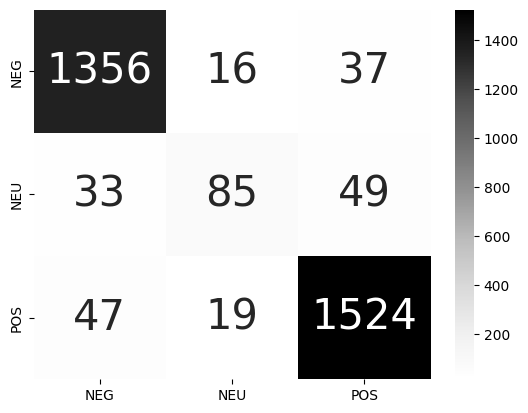

In [14]:
test_cm = evaluate(true_labels, predicts)
labels = ['NEG', 'NEU', 'POS']
predicts
plotting_confusion_matrix(labels, test_cm, model_name)

In [15]:

predict_df = pd.DataFrame({'Text': uit_vsfc_test_df['text'],
                           'true_label': true_labels, 'predict': predicts})
predict_df.to_csv(os.path.join(model_name, f'{model_name}_test_prediction.csv'), index=False)
wrong_df = predict_df[predict_df.true_label != predict_df.predict]
sorted_df = wrong_df.sort_values(['true_label', 'predict'], ascending=[False, False])
sorted_df

,Text,true_label,predict
6,tính điểm thi đua các nhóm .,POS,NEU
12,trong trường macbook thầy số hai thì không có ...,POS,NEU
291,sinh viên hiểu thầy mới cho về .,POS,NEU
300,có giờ tiếp sinh viên .,POS,NEU
486,cám ơn cô đã dạy lớp em .,POS,NEU
...,...,...,...
2158,có lời cho công việc sau này của mình không .,NEG,NEU
2473,wzjwz217 là thầy nào ?,NEG,NEU
2630,đồng nhất một giáo trình giảng dạy .,NEG,NEU
2749,chỉ có 1 điểm em không hài lòng đó là đề thi c...,NEG,NEU


### aivivn-2019

In [16]:
model_name="Vietnamese-Sentiment-visobert"
true_labels, predicts = test(aivivn_test_df, model_path, device, numlabels = 2)


>>> Đang đánh giá mô hình: 5CD-AI/Vietnamese-Sentiment-visobert


100%|██████████| 3217/3217 [00:41<00:00, 76.92it/s]


Accuracy: 0.9341
Precision: 0.9307
Recall: 0.9367
F1-score: 0.9330
Confusion matrix:
 [[1298   63]
 [ 149 1707]]
              precision    recall  f1-score   support

         NEG     0.8970    0.9537    0.9245      1361
         POS     0.9644    0.9197    0.9415      1856

    accuracy                         0.9341      3217
   macro avg     0.9307    0.9367    0.9330      3217
weighted avg     0.9359    0.9341    0.9343      3217



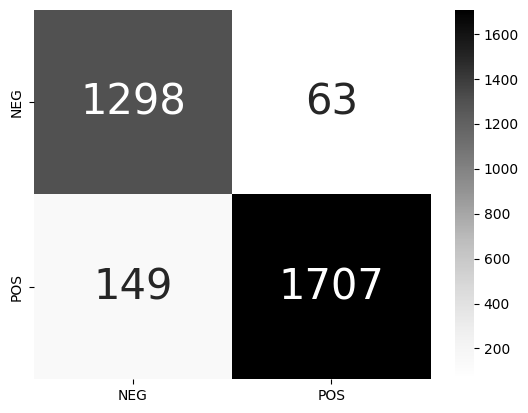

In [17]:
test_cm = evaluate(true_labels, predicts)
labels = [ 'NEG', 'POS']

plotting_confusion_matrix(labels, test_cm, model_name)

In [18]:

predict_df = pd.DataFrame({'Text': aivivn_test_df['text'],
                           'true_label': true_labels, 'predict': predicts})
predict_df.to_csv(os.path.join(model_name, f'{model_name}_test_prediction.csv'), index=False)
wrong_df = predict_df[predict_df.true_label != predict_df.predict]
sorted_df = wrong_df.sort_values(['true_label', 'predict'], ascending=[False, False])
sorted_df

,Text,true_label,predict
30,Form hơi nhỏ,POS,NEG
45,may rat do luc may thi keu rat to noi chung la...,POS,NEG
46,Áo ko đúng màu yêu cầu lấy đỏ lại giao hồng,POS,NEG
53,Mạng cực kì kém không thể dùng được. Thất vọng...,POS,NEG
58,Shop ship hơi chậm,POS,NEG
...,...,...,...
3004,em rất yêu anh thời gian càng trôi em yêu anh ...,NEG,POS
3031,"Tôi cũng mong lắm , nếu như các vị lãnh đạo "" ...",NEG,POS
3113,Thấy bạn gói kĩ lắm 😊 nhưng mà bị như này thì ...,NEG,POS
3156,tạm được !,NEG,POS


## phobert-base-vietnamese-sentiment

In [19]:

sentence = ''' Dm mới kéo cái tuột luôn cái kính cường lực🙂
R phải cầm cái kính tự dán🙂 để lâu quá nó dính hai cục bụi lên nữa chứ má bực thiệt chứ
Hình như tại hai cái cục nam châm nó xúc ra 😑'''
print('Sentence: ', sentence)

model_path = 'wonrax/phobert-base-vietnamese-sentiment'
print("Loading sentiment analysis model..." + model_path)
tokenizer, model, label_map = load_model_and_tokenizer(model_path, device)
analyze_sentiment(sentence, tokenizer, model, label_map, device)

Sentence:   Dm mới kéo cái tuột luôn cái kính cường lực🙂
R phải cầm cái kính tự dán🙂 để lâu quá nó dính hai cục bụi lên nữa chứ má bực thiệt chứ
Hình như tại hai cái cục nam châm nó xúc ra 😑
Loading sentiment analysis model...wonrax/phobert-base-vietnamese-sentiment


tokenizer_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/999 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

{'NEG': 0.9719, 'NEU': 0.0197, 'POS': 0.0084, 'label': 'NEG'}

### uit_vsfc

In [20]:
model_name="Vietnamese-Sentiment-visobert"
model_path = 'wonrax/phobert-base-vietnamese-sentiment'
true_labels, predicts = test(uit_vsfc_test_df, model_path, device)


>>> Đang đánh giá mô hình: wonrax/phobert-base-vietnamese-sentiment



100%|██████████| 3166/3166 [00:42<00:00, 74.66it/s]


Accuracy: 0.7044
Precision: 0.6207
Recall: 0.6543
F1-score: 0.5826
Confusion matrix:
 [[ 769  441  199]
 [  17   93   57]
 [  87  135 1368]]
              precision    recall  f1-score   support

         NEG     0.8809    0.5458    0.6740      1409
         NEU     0.1390    0.5569    0.2225       167
         POS     0.8424    0.8604    0.8513      1590

    accuracy                         0.7044      3166
   macro avg     0.6207    0.6543    0.5826      3166
weighted avg     0.8224    0.7044    0.7392      3166



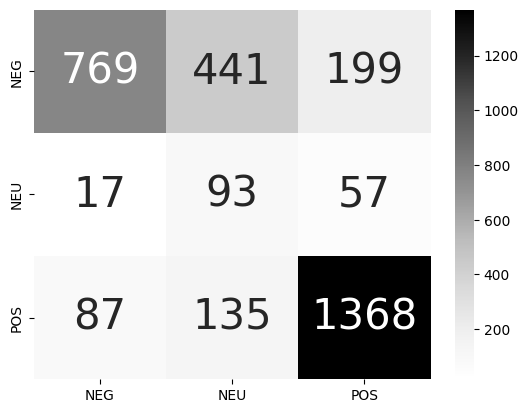

In [21]:
test_cm = evaluate(true_labels, predicts)
labels = ['NEG', 'NEU', 'POS']
predicts
plotting_confusion_matrix(labels, test_cm, model_name)

In [22]:

predict_df = pd.DataFrame({'Text': uit_vsfc_test_df['text'],
                           'true_label': true_labels, 'predict': predicts})
predict_df.to_csv(os.path.join(model_name, f'{model_name}_test_prediction.csv'), index=False)
wrong_df = predict_df[predict_df.true_label != predict_df.predict]
sorted_df = wrong_df.sort_values(['true_label', 'predict'], ascending=[False, False])
sorted_df

,Text,true_label,predict
6,tính điểm thi đua các nhóm .,POS,NEU
7,thầy nhiệt tình giảng lại cho học sinh .,POS,NEU
39,cung cấp bài tập đa dạng .,POS,NEU
43,"cô vui tính , học không áp lực .",POS,NEU
46,thầy nhiệt tình trả lời thắc mắc của sinh viên .,POS,NEU
...,...,...,...
3143,em là một học sinh không lười biếng nhưng thầy...,NEG,NEU
3145,không quan tâm sinh viên có nắm được kiến thức...,NEG,NEU
3147,cho sinh viên thực hành một đề bài quản lý thô...,NEG,NEU
3152,nếu có phần mềm minh họa cho các thuật toán th...,NEG,NEU


### aivivn-2019

In [23]:
model_name="Vietnamese-Sentiment-visobert"
true_labels, predicts = test(aivivn_test_df, model_path, device, numlabels = 2)


>>> Đang đánh giá mô hình: wonrax/phobert-base-vietnamese-sentiment


100%|██████████| 3217/3217 [00:42<00:00, 76.07it/s]


Accuracy: 0.8806
Precision: 0.8784
Recall: 0.8767
F1-score: 0.8775
Confusion matrix:
 [[1158  203]
 [ 181 1675]]
              precision    recall  f1-score   support

         NEG     0.8648    0.8508    0.8578      1361
         POS     0.8919    0.9025    0.8972      1856

    accuracy                         0.8806      3217
   macro avg     0.8784    0.8767    0.8775      3217
weighted avg     0.8804    0.8806    0.8805      3217



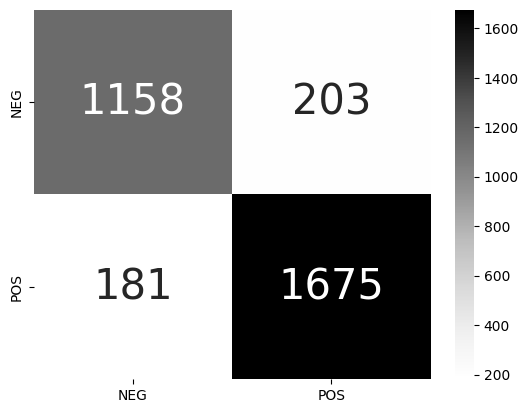

In [24]:
test_cm = evaluate(true_labels, predicts)
labels = [ 'NEG', 'POS']

plotting_confusion_matrix(labels, test_cm, model_name)

In [25]:

predict_df = pd.DataFrame({'Text': aivivn_test_df['text'],
                           'true_label': true_labels, 'predict': predicts})
predict_df.to_csv(os.path.join(model_name, f'{model_name}_test_prediction.csv'), index=False)
wrong_df = predict_df[predict_df.true_label != predict_df.predict]
sorted_df = wrong_df.sort_values(['true_label', 'predict'], ascending=[False, False])
sorted_df

,Text,true_label,predict
3,Bim tốt. Ung hộ shop dai dai,POS,NEG
30,Form hơi nhỏ,POS,NEG
46,Áo ko đúng màu yêu cầu lấy đỏ lại giao hồng,POS,NEG
53,Mạng cực kì kém không thể dùng được. Thất vọng...,POS,NEG
58,Shop ship hơi chậm,POS,NEG
...,...,...,...
3183,"""Độ nhạy tối đa 6400iso, 3 hình/giây. Công ngh...",NEG,POS
3186,Chọn xanh chuối với sám thì lại cho đỏ,NEG,POS
3209,K được như mong muốn. Đúng là tiền nào của đấy,NEG,POS
3211,Thời gian giao hàng rất nhanh Dùng ngứa vs lê...,NEG,POS
